CNN Classifier for Dental Implants



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
import shutil

Download dataset

In [2]:
#install to download the dataset easily
!pip install -U --no-cache-dir gdown --pre

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [3]:
#download dataset
!gdown 18wEiRTNkFRp5Xlt1pvtw8q7Me_lENX21

Downloading...
From: https://drive.google.com/uc?id=18wEiRTNkFRp5Xlt1pvtw8q7Me_lENX21
To: /content/Dental.rar
100% 40.1M/40.1M [00:01<00:00, 24.4MB/s]


In [4]:
#unzip dataset
!unrar x "/content/Dental.rar" 


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/Dental.rar

Creating    Dental                                                    OK
Creating    Dental/Argon                                              OK
Extracting  Dental/Argon/1252.PNG                                          0%  OK 
Extracting  Dental/Argon/170861378_181773640455697_8868278685022032298_n_03.jpg       0%  OK 
Extracting  Dental/Argon/170997132_181773687122359_801184412197855815_n_03.jpg       0%  OK 
Extracting  Dental/Argon/172042944_181773760455685_5660686353046769448_n_03.jpg       0%  OK 
Extracting  Dental/Argon/2123.PNG                                          0%  OK 
Extracting  Dental/Argon/215339849_1394213794283356_2287391585413002973_n_03.jpg       0%  OK 
Extracting  Dental/Argon/215339849_1394213794283356_2287391585413002973_n_06.jpg       0%  OK 
Extracting  Dental/Argon/215339849_1394213794283

Explore dataset

(252, 138, 4)


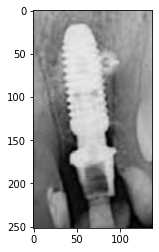

In [6]:
# Read and plot image 
def read_and_display(image):
    image = plt.imread(image)
    plt.imshow(image)
    print(image.shape)
    
read_and_display("/content/Dental/Argon/2123.PNG")

In [7]:
source = '/content/Dental'

print("Number of classes before del = ", len(os.listdir(source)))

Number of classes before del =  60


In [8]:
for f in os.listdir(source):  
    images = os.listdir(os.path.join(source, f))
    n_images = len(images)
    if n_images < 25 : 
        shutil.rmtree(os.path.join(source, f), ignore_errors=True)

print("Number of classes after del = ", len(os.listdir(source)))

Number of classes after del =  41


Train/Test split


In [9]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import splitfolders
# Split with a ratio.
splitfolders.ratio("/content/Dental", output="/content/data", 
                   seed=816, ratio=(.85, .075, .075), 
                   group_prefix=None)

Copying files: 2173 files [00:00, 3900.23 files/s]


Model building

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model
from keras.layers import Input, AveragePooling2D, GlobalAveragePooling2D
from keras.layers import concatenate

In [12]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        # rotation_range=45,
        # width_shift_range=0.2,
        # height_shift_range=0.2,
        # shear_range=0.2,
        # zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='wrap')  

In [13]:
batch_size = 64
img_height = 227
img_width = 227
image_size = (img_height, img_width)
inputs = Input((img_height, img_width, 3))

In [14]:
train_dir = '/content/data/train'
train_generator=datagen.flow_from_directory(
                        directory=train_dir,
                        batch_size=batch_size,
                        seed=50,
                        shuffle=True,
                        class_mode="categorical",
                        color_mode="rgb",
                        target_size=image_size)

Found 1828 images belonging to 41 classes.


In [15]:
val_dir = '/content/data/val'
valid_generator=datagen.flow_from_directory(
                        directory=val_dir,
                        batch_size=batch_size,
                        seed=42,
                        shuffle=True,
                        class_mode="categorical",
                        color_mode="rgb",
                        target_size=image_size)

Found 144 images belonging to 41 classes.


In [16]:
test_dir = '/content/data/test'
test_generator=datagen.flow_from_directory(
                            directory=test_dir,
                            batch_size=1,
                            seed=42,
                            shuffle=False,
                            class_mode="categorical",
                            color_mode="rgb",
                            target_size=image_size)

Found 201 images belonging to 41 classes.


In [17]:
STEP_SIZE_TRAIN=len(train_generator)
STEP_SIZE_VALID=len(valid_generator)
print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)

29
3


AlexNet model




In [18]:
alexnet_model=Sequential()

#1 convolutional layer
alexnet_model.add(Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),padding="valid",activation="relu",input_shape=(227,227,3)))
#1 max pool layer
alexnet_model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

#2 convolutional layer
alexnet_model.add(Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),padding="valid",activation="relu"))

#2 max pool layer
alexnet_model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

alexnet_model.add(BatchNormalization())

#3 convolutional layer
alexnet_model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#4 convolutional layer
alexnet_model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#5 convolutional layer
alexnet_model.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#3 max pool layer
alexnet_model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

alexnet_model.add(BatchNormalization())

alexnet_model.add(Flatten())

#1 dense layer
alexnet_model.add(Dense(4096,input_shape=(227,227,3),activation="relu"))

alexnet_model.add(Dropout(0.4))

alexnet_model.add(BatchNormalization())

#2 dense layer
alexnet_model.add(Dense(4096,activation="relu"))

alexnet_model.add(Dropout(0.4))

alexnet_model.add(BatchNormalization())

#3 dense layer
alexnet_model.add(Dense(1000,activation="relu"))

alexnet_model.add(Dropout(0.4))

alexnet_model.add(BatchNormalization())

#output layer
alexnet_model.add(Dense(41,activation="softmax"))

alexnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 256)      0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 11, 11, 256)      1024      
 ormalization)                                                   
                                                        

In [19]:
alexnet_model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])

In [20]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

filepath="/content/" + "alexnet_weights.h5"
checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=True)
callbacks_list = [checkpoint, es]

alexnet_history = alexnet_model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=100,
                    shuffle = True, 
                    callbacks=callbacks_list)

Epoch 1/100
29/29 [==============================] - ETA: 0s - loss: 4.3633 - accuracy: 0.0509
Epoch 1: val_loss improved from inf to 1311.51172, saving model to /content/alexnet_weights.h5
29/29 [==============================] - 191s 7s/step - loss: 4.3633 - accuracy: 0.0509 - val_loss: 1311.5117 - val_accuracy: 0.0139
Epoch 2/100
29/29 [==============================] - ETA: 0s - loss: 3.9588 - accuracy: 0.0673
Epoch 2: val_loss improved from 1311.51172 to 280.24423, saving model to /content/alexnet_weights.h5
29/29 [==============================] - 179s 6s/step - loss: 3.9588 - accuracy: 0.0673 - val_loss: 280.2442 - val_accuracy: 0.0208
Epoch 3/100
29/29 [==============================] - ETA: 0s - loss: 3.8101 - accuracy: 0.0842
Epoch 3: val_loss improved from 280.24423 to 124.52855, saving model to /content/alexnet_weights.h5
29/29 [==============================] - 173s 6s/step - loss: 3.8101 - accuracy: 0.0842 - val_loss: 124.5285 - val_accuracy: 0.0208
Epoch 4/100
29/29 [===

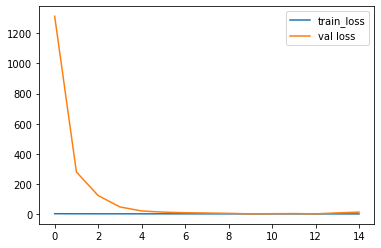

In [21]:
# Plot the Loss
plt.plot(alexnet_history.history['loss'], label = 'train_loss')
plt.plot(alexnet_history.history['val_loss'], label ='val loss')
plt.legend()
plt.show()

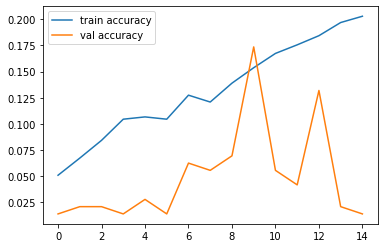

In [22]:
# Plot the Accuracy
plt.plot(alexnet_history.history['accuracy'], label = 'train accuracy')
plt.plot(alexnet_history.history['val_accuracy'], label ='val accuracy')
plt.legend()
plt.show()

Evaluate the model

In [23]:
alexnet_model.evaluate(test_generator, batch_size=128)

201/201 [==============================] - 9s 46ms/step - loss: 3.4635 - accuracy: 0.1144


[3.463474750518799, 0.11442785710096359]